In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import set_config
set_config(transform_output="pandas") 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

from projet_3_struct.funcs_features import build_manual_features, select_numeric

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# 1) Chargement
df = pd.read_csv("building_consumption_pour_analyses.csv")

# 2) CIBLE = énergie ajustée, puis log1p (comme ton manuel)
y_raw = (
    pd.to_numeric(df['SiteEnergyUseWN(kBtu)'], errors='coerce')
    * pd.to_numeric(df['PartNonHabitation(%)'], errors='coerce') / 100.0
)
mask = y_raw.notna() & (y_raw > 0)
df = df.loc[mask].copy()
y_log = np.log1p(y_raw.loc[mask].copy())   # ⬅️ cible en log1p

# 3) Préprocessing “parité 100%” (features identiques à ton manuel)
preproc = Pipeline([
    ("build", FunctionTransformer(
        build_manual_features,
        kw_args=dict(
            include_defaultdata=False,
            # on force explicitement ces deux kwargs :
            log_cols=None,
            drop_text_groups=True,
            # et on précise bien les catégorielles à dummy-fier :
            cat_cols=[
                'BuildingType', 'CouncilDistrictCode', 'Usage_multiple',
                'PrimaryPropertyType', 'DefaultData','Neighborhood'
            ],
        ),
        validate=False
    )),
    ("select", FunctionTransformer(select_numeric, validate=False)),
])
X_all = preproc.fit_transform(df)

# (facultatif) vérifie qu’il n’y a plus de NaN
na_cols = X_all.columns[X_all.isna().any()]
if len(na_cols):
    print("Colonnes avec NaN:", list(na_cols))  # ne devrait rien afficher

# 4) Split identique
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_log, train_size=0.8, random_state=42
)

# 5) Modèles (identiques)

def report(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    print(f"{name:>12} | R2: {r2_score(yte, y_pred):.12f} | RMSE: {root_mean_squared_error(yte, y_pred):.12f} | MAE: {mean_absolute_error(yte, y_pred):.12f}")

report("LinearReg", LinearRegression(), X_train, y_train, X_test, y_test)
report("DummyMean", DummyRegressor(strategy="mean"), X_train, y_train, X_test, y_test)
report("SVR",       SVR(), X_train, y_train, X_test, y_test)
report("RF(maxd5)", RandomForestRegressor(max_depth=5, random_state=42), X_train, y_train, X_test, y_test)
report("GBoost",    GradientBoostingRegressor(random_state=42), X_train, y_train, X_test, y_test)

   LinearReg | R2: 0.765504156807 | RMSE: 0.749890598610 | MAE: 0.546634885813
   DummyMean | R2: -0.002458736066 | RMSE: 1.550470783808 | MAE: 1.217630671676
         SVR | R2: 0.140507497561 | RMSE: 1.435659274521 | MAE: 1.115600991988
   RF(maxd5) | R2: 0.727209606691 | RMSE: 0.808806942795 | MAE: 0.574383803255
      GBoost | R2: 0.754475897913 | RMSE: 0.767321558679 | MAE: 0.553897858457


In [19]:
# === GridSearch sur la famille linéaire (Ridge / Lasso / ElasticNet)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

lin_pipe = Pipeline([
    ("scaler", StandardScaler()),     # important pour Lasso / ElasticNet
    ("model", Ridge())                # placeholder remplacé par le grid
])

param_grid = [
    # Ridge
    {
        "model": [Ridge()],
        "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
        "model__fit_intercept": [True, False],
        # solver court pour rester "petit" (comme demandé)
        "model__solver": ["auto", "sag"],
    },
    # Lasso
    {
        "model": [Lasso(max_iter=10000)],
        "model__alpha": [0.0005, 0.001, 0.005, 0.01, 0.1],
        "model__fit_intercept": [True, False],
        "model__selection": ["cyclic", "random"],
    },
    # ElasticNet
    {
        "model": [ElasticNet(max_iter=10000)],
        "model__alpha": [0.001, 0.01, 0.1, 1.0],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__fit_intercept": [True, False],
    },
]

lin_cv = GridSearchCV(
    estimator=lin_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE en espace log (puisque y est log1p)
    n_jobs=-1,
    verbose=1,
)

lin_cv.fit(X_train, y_train)

print("Meilleurs params (linéaire régularisé):", lin_cv.best_params_)
print("Meilleur CV RMSE:", -lin_cv.best_score_)

best_lin = lin_cv.best_estimator_
y_pred = best_lin.predict(X_test)

print("\n[TEST] R2  :", r2_score(y_test, y_pred))
print("[TEST] RMSE:", root_mean_squared_error(y_test, y_pred))
print("[TEST] MAE :", mean_absolute_error(y_test, y_pred))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Meilleurs params (linéaire régularisé): {'model': Lasso(max_iter=10000), 'model__alpha': 0.005, 'model__fit_intercept': True, 'model__selection': 'cyclic'}
Meilleur CV RMSE: 0.7568375517044406

[TEST] R2  : 0.7655356654114447
[TEST] RMSE: 0.7498402164802941
[TEST] MAE : 0.5443803271141445


In [21]:
from sklearn.inspection import permutation_importance
import pandas as pd

# On évalue sur le set de test pour une importance plus honnête
perm = permutation_importance(
    best_lin, X_test, y_test,
    scoring="neg_root_mean_squared_error",  # cohérent avec le GridSearch
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
)

imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

print("\nTop 25 features (Permutation Importance):")
print(imp_df.head(30).to_string(index=False))



Top 25 features (Permutation Importance):
                                        feature  importance_mean  importance_std
                               PropertyGFATotal     6.276452e-01    2.209568e-02
       PrimaryPropertyType_Low-Rise Multifamily     3.130463e-01    1.907977e-02
                    BuildingType_NonResidential     1.976981e-01    1.640725e-02
       PrimaryPropertyType_Mid-Rise Multifamily     1.501318e-01    1.168895e-02
      PrimaryPropertyType_High-Rise Multifamily     6.895997e-02    6.797322e-03
                  PrimaryPropertyType_Warehouse     3.556904e-02    8.008257e-03
      PrimaryPropertyType_Self-Storage Facility     2.845426e-02    4.516737e-03
PrimaryPropertyType_Supermarket / Grocery Store     2.666261e-02    8.168407e-03
                      PrimaryPropertyType_Other     1.979618e-02    4.155894e-03
                 PrimaryPropertyType_Laboratory     1.752146e-02    5.428710e-03
                 BuildingType_SPS-District K-12     1.476818e-02  

In [22]:
model = best_lin.named_steps["model"]
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_
}).assign(abs_coef=lambda d: d["coef"].abs()
).sort_values("abs_coef", ascending=False)

print("\nTop 25 coefficients (absolus):")
print(coef_df.head(25).to_string(index=False))



Top 25 coefficients (absolus):
                                        feature      coef  abs_coef
                               PropertyGFATotal  0.782944  0.782944
       PrimaryPropertyType_Low-Rise Multifamily -0.540887  0.540887
                    BuildingType_NonResidential  0.395219  0.395219
       PrimaryPropertyType_Mid-Rise Multifamily -0.349462  0.349462
      PrimaryPropertyType_High-Rise Multifamily -0.194221  0.194221
PrimaryPropertyType_Supermarket / Grocery Store  0.193157  0.193157
                  PrimaryPropertyType_Warehouse -0.145022  0.145022
      PrimaryPropertyType_Self-Storage Facility -0.126328  0.126328
                 BuildingType_SPS-District K-12  0.104157  0.104157
                 PrimaryPropertyType_Laboratory  0.104070  0.104070
                      PrimaryPropertyType_Other  0.092754  0.092754
              BuildingType_Multifamily MR (5-9) -0.091743  0.091743
      PrimaryPropertyType_Senior Care Community  0.079290  0.079290
                

In [24]:
parameters = {"n_estimators":  [200, 400, 800],
    "learning_rate": [0.05, 0.10, 0.20],
    "max_depth":     [2, 3, 4],
    "subsample":     [0.7, 0.9, 1.0],
    "max_features":  [None, "sqrt", 0.5],
    "min_samples_leaf": [1, 5, 10],
}

model = GradientBoostingRegressor(
    random_state = 42
)

clf = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = 1)
clf.fit(X_train, y_train)

print("Meilleur params:", clf.best_params_)
print("Meilleur CV RMSE:", -clf.best_score_)

best = clf.best_estimator_
y_pred = best.predict(X_test)
print("\n[TEST] R2  :", r2_score(y_test, y_pred))
print("[TEST] RMSE:", root_mean_squared_error(y_test, y_pred))
print("[TEST] MAE :", mean_absolute_error(y_test, y_pred))

# --- Importances des features (arbres) ---
importances = best.feature_importances_
fi = pd.Series(importances, index=getattr(X_train, "columns", range(len(importances))))
fi = fi.sort_values(ascending=False)
print("\nTop features :")
print(fi.head(30).to_string(index=True))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Meilleur params: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 400, 'subsample': 0.9}
Meilleur CV RMSE: 0.7617095533135496

[TEST] R2  : 0.7702446442692987
[TEST] RMSE: 0.7422721335080058
[TEST] MAE : 0.5391207729972379

Top features :
PropertyGFATotal                                   0.271944
BuildingType_NonResidential                        0.160777
BuildingType_Multifamily LR (1-4)                  0.114861
PrimaryPropertyType_Low-Rise Multifamily           0.097273
PrimaryPropertyType_Mid-Rise Multifamily           0.055009
PropertyGFAParking                                 0.042261
PrimaryPropertyType_Large Office                   0.024360
PrimaryPropertyType_Supermarket / Grocery Store    0.023671
BuildingType_Multifamily MR (5-9)                  0.021801
Groupe_nb_etages_label                             0.015227
Latitude                                   

In [ ]:
# mêmes préfixes que dans funcs_features.py
DUMMY_PREFIXES = [
    'BuildingType_', 'CouncilDistrictCode_', 'Usage_multiple_',
    'PrimaryPropertyType_', 'DefaultData_', 'Neighborhood_'
]

def unscale_linear_coefs(best_pipe, Xref: pd.DataFrame):
    """Coefficients dans l'échelle d'origine des X (et intercept)."""
    scaler = best_pipe.named_steps["scaler"]
    model  = best_pipe.named_steps["model"]

    cols  = Xref.columns
    scale = pd.Series(scaler.scale_, index=cols)   # std (population) utilisée par StandardScaler
    mean  = pd.Series(scaler.mean_,  index=cols)

    beta_std = pd.Series(model.coef_, index=cols)
    beta_unscaled = beta_std / scale
    intercept_unscaled = model.intercept_ - (mean * beta_unscaled).sum()

    coefs = pd.DataFrame({
        "feature": cols,
        "coef_orig": beta_unscaled.values,   # β dans l'échelle d'origine
        "coef_std": beta_std.values          # β après standardisation (pour info)
    })
    return coefs.set_index("feature"), intercept_unscaled

def top_effects_percent(best_pipe, Xref: pd.DataFrame, topn: int = 20):
    """
    Calcule l'effet % sur la cible (log1p) :
      - dummies : 0→1
      - continues : +1 écart-type (échelle d'origine)
    Retourne un DataFrame trié par |effet %|.
    """
    coefs, _ = unscale_linear_coefs(best_pipe, Xref)

    # détecte dummies par préfixe OU par valeurs {0,1}
    is_dummy = {}
    for f in Xref.columns:
        if any(f.startswith(p) for p in DUMMY_PREFIXES):
            is_dummy[f] = True
        else:
            vals = pd.Series(Xref[f].dropna().unique())
            is_dummy[f] = set(vals.astype(float).round().unique()).issubset({0.0, 1.0}) and len(vals) <= 3

    stds = Xref.std(ddof=0)  # std population, alignée avec StandardScaler
    rows = []
    for f in Xref.columns:
        beta = coefs.loc[f, "coef_orig"]
        if is_dummy[f]:
            delta_x = 1.0
            kind = "dummy"
        else:
            delta_x = float(stds.get(f, 0.0))  # +1 écart-type
            kind = "continuous"

        # effet % sur (1+y) ~ sur y si y grand
        effect_pct = 100.0 * (np.exp(beta * delta_x) - 1.0)

        rows.append({
            "feature": f,
            "kind": kind,
            "coef_orig": beta,
            "delta_x": delta_x,
            "effect_pct": effect_pct,
            "abs_effect_pct": abs(effect_pct),
            "std_X": stds.get(f, np.nan),
        })

    out = pd.DataFrame(rows).sort_values("abs_effect_pct", ascending=False).head(topn)
    return out

# --- utilisation ---
effects = top_effects_percent(best_lin, X_train, topn=20)
print(effects[["feature","kind","coef_orig","delta_x","effect_pct"]].to_string(index=False))

                                        feature       kind  coef_orig  delta_x  effect_pct
                 PrimaryPropertyType_Laboratory      dummy   1.705520 1.000000  450.424542
PrimaryPropertyType_Supermarket / Grocery Store      dummy   1.446832 1.000000  324.962977
                   PrimaryPropertyType_Hospital      dummy   1.136150 1.000000  211.475415
                 PrimaryPropertyType_Restaurant      dummy   1.072880 1.000000  192.378819
                    BuildingType_NonResidential      dummy   0.820330 1.000000  127.124907
                               PropertyGFATotal continuous   0.959324 0.816141  118.790385
      PrimaryPropertyType_Senior Care Community      dummy   0.665212 1.000000   94.490325
       PrimaryPropertyType_Low-Rise Multifamily      dummy  -1.501590 1.000000  -77.722439
                 BuildingType_SPS-District K-12      dummy   0.569077 1.000000   76.663512
      PrimaryPropertyType_Self-Storage Facility      dummy  -1.229088 1.000000  -70.744083

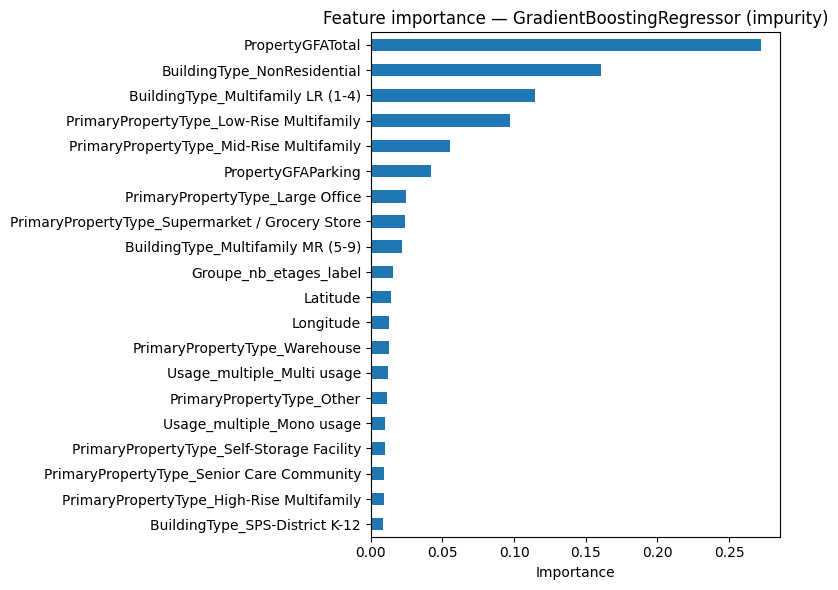

In [27]:
fi = pd.Series(best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top = fi.head(20)
plt.figure(figsize=(8,6))
top.iloc[::-1].plot(kind="barh")
plt.title("Feature importance — GradientBoostingRegressor (impurity)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

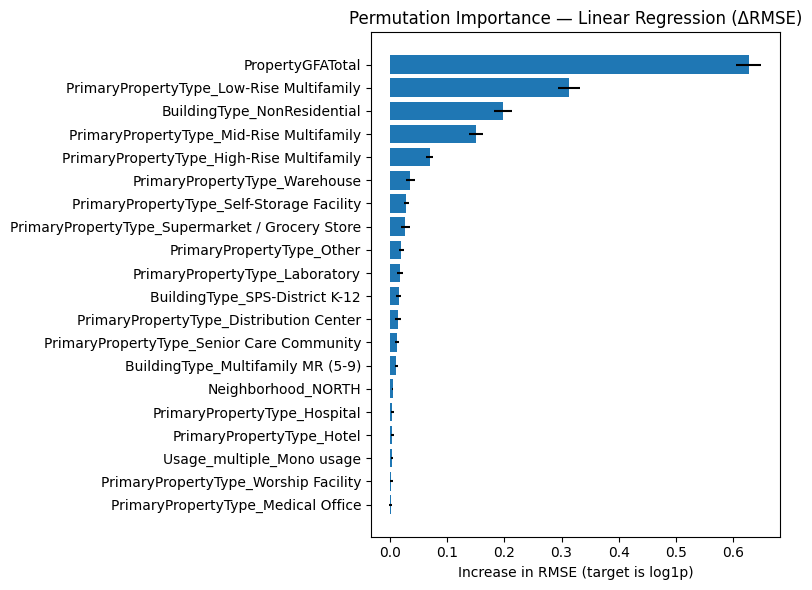

In [28]:
# best_lin is your best estimator from GridSearchCV
perm = permutation_importance(
    best_lin, X_test, y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=20, random_state=42, n_jobs=-1,
)

imp_mean = pd.Series(perm.importances_mean, index=X_test.columns)
imp_std  = pd.Series(perm.importances_std,  index=X_test.columns)
top = imp_mean.sort_values(ascending=False).head(20)
top_err = imp_std.loc[top.index]

plt.figure(figsize=(8, 6))
plt.barh(top.index[::-1], top.values[::-1], xerr=top_err.values[::-1])
plt.title("Permutation Importance — Linear Regression (ΔRMSE)")
plt.xlabel("Increase in RMSE (target is log1p)")
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, median_absolute_error

# 1) Prédictions en log1p (ton modèle renvoie du log1p)
y_pred_log = best_lin.predict(X_test)

# 2) Métriques en log (inchangé)
r2_log   = r2_score(y_test, y_pred_log)
rmse_log = root_mean_squared_error(y_test, y_pred_log)

# 3) Back-transform vers l’échelle métier (kBtu)
y_true_kbtu = np.expm1(y_test)
y_pred_kbtu = np.expm1(y_pred_log)

# Option sécurité : pas de valeurs négatives après expm1
y_pred_kbtu = np.clip(y_pred_kbtu, a_min=0, a_max=None)

# 4) Métriques métier
mae_kbtu   = mean_absolute_error(y_true_kbtu, y_pred_kbtu)
rmse_kbtu  = root_mean_squared_error(y_true_kbtu, y_pred_kbtu)
medae_kbtu = median_absolute_error(y_true_kbtu, y_pred_kbtu)

# 5) Résumé clair
print(f"Notre modèle explique ~{r2_log*100:.1f}% de la variance (R², espace log).")
print(f"Sur l’échelle métier :")
print(f"  • MAE  ≈ {mae_kbtu:,.0f} kBtu (erreur absolue moyenne)")
print(f"  • MedAE ≈ {medae_kbtu:,.0f} kBtu (erreur absolue médiane)")
print(f"  • RMSE ≈ {rmse_kbtu:,.0f} kBtu (écart-type des erreurs)")

Notre modèle explique ~76.6% de la variance (R², espace log).
Sur l’échelle métier :
  • MAE  ≈ 2,037,933 kBtu (erreur absolue moyenne)
  • MedAE ≈ 568,479 kBtu (erreur absolue médiane)
  • RMSE ≈ 5,573,901 kBtu (écart-type des erreurs)
